In [62]:
from google.colab import files
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [3]:
# Upload CSV file
uploaded = files.upload()

# Read CSV into DataFrame (replace with your actual filename)
df = pd.read_csv('diabetic_data.csv')

Saving diabetic_data.csv to diabetic_data.csv


In [4]:
# Check first few rows
df.head(5)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


## Inspect Schema

In [5]:
print(df.shape)
print(df.columns)

(101766, 50)
Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

In [7]:
# Numerical features
num_features = df.select_dtypes(include=['int64', 'float64']).columns
print("Number of numerical features:", len(num_features))
print("Numerical features:", list(num_features))

# Categorical features
cat_features = df.select_dtypes(include=['object', 'category']).columns
print("\nNumber of categorical features:", len(cat_features))
print("Categorical features:", list(cat_features))

Number of numerical features: 13
Numerical features: ['encounter_id', 'patient_nbr', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']

Number of categorical features: 37
Categorical features: ['race', 'gender', 'age', 'weight', 'payer_code', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted']


In [8]:
print("Unique encounter_id:", df['encounter_id'].nunique())
print("Unique patient_nbr:", df['patient_nbr'].nunique())

Unique encounter_id: 101766
Unique patient_nbr: 71518


## Data Cleaning
**1. Visualize missing values in heatmap.**

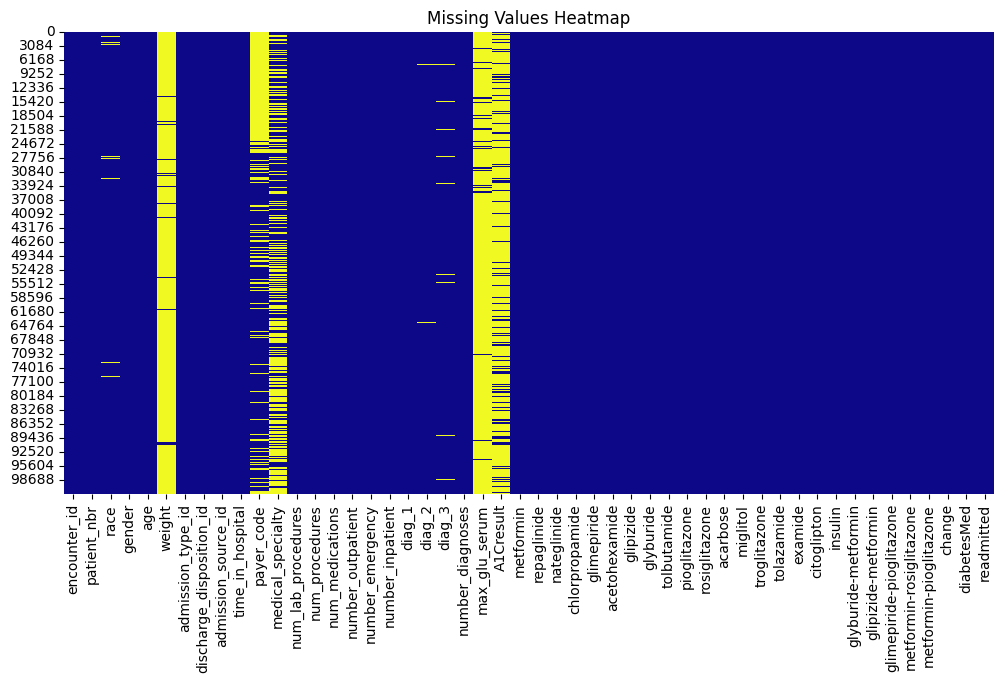

In [9]:
# Replace '?' with NaN first
df.replace('?', pd.NA, inplace=True)

# Plot heatmap of missing values
plt.figure(figsize=(12,6))
sns.heatmap(df.isna(), cbar=False, cmap='plasma')
plt.title("Missing Values Heatmap")
plt.show()

  **2. Removed features ('weight', 'payer_code', 'medical_specialty') with high missing values and irrelevant to modeling.**

In [10]:
# Percent of missing value in 'weight'
weight_missing_pct = df['weight'].isna().mean() * 100
print("Percent of missing value in 'weight':", weight_missing_pct)

# Percent of missing value in 'payer_code'
payer_code_missing_pct = df['payer_code'].isna().mean() * 100
print("\nPercent of missing value in 'payer_code':", payer_code_missing_pct)

# Percent of missing value in 'medical_specialty'
medical_specialty_missing_pct = df['medical_specialty'].isna().mean() * 100
print("\nPercent of missing value in 'medical_specialty':", medical_specialty_missing_pct)

Percent of missing value in 'weight': 96.85847925633315

Percent of missing value in 'payer_code': 39.5574160328597

Percent of missing value in 'medical_specialty': 49.08220820313268


In [11]:
columns_to_drop = ['weight', 'payer_code', 'medical_specialty']
df.drop(columns=columns_to_drop, inplace=True)

# Check the first few rows
df.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),6,25,1,1,41,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),1,1,7,3,59,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),1,1,7,2,11,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,44,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,51,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


  **3. NaN values in 'max_glu_serum' and 'A1Cresult' are replaced with 'None' for later ICD-9-based categorical mapping.**

In [12]:
# Observe values of 'max_glu_serum'
print("Unique values of 'max_glu_serum':", df['max_glu_serum'].unique())

# Observe values of 'A1Cresult'
print("Unique values of 'A1Cresult':", df['A1Cresult'].unique())

# Replace NaN with 'None'
df['max_glu_serum'] = df['max_glu_serum'].fillna('None')
df['A1Cresult'] = df['A1Cresult'].fillna('None')

Unique values of 'max_glu_serum': [nan '>300' 'Norm' '>200']
Unique values of 'A1Cresult': [nan '>7' '>8' 'Norm']


  **4. Drop unbalanced features with more than 95% same value.**

In [13]:
# Threshold for unbalanced columns
threshold = 0.95

# Find columns where the most frequent value exceeds the threshold
unbalanced_cols = [col for col in df.columns if df[col].value_counts(normalize=True, dropna=False).max() > threshold]

print("Unbalanced columns (>95% same value):", unbalanced_cols)

Unbalanced columns (>95% same value): ['repaglinide', 'nateglinide', 'chlorpropamide', 'acetohexamide', 'tolbutamide', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone']


In [14]:
df.drop(columns=unbalanced_cols, inplace=True)

## Feature Engineering
  **1. Fix `gender` feature:** removed 3 entries of unknown/invalid gender.

In [15]:
# Observe values of 'gender'
print(df['gender'].value_counts(dropna=False))

gender
Female             54708
Male               47055
Unknown/Invalid        3
Name: count, dtype: int64


In [16]:
# Keep only rows where gender is 'Male' or 'Female'
df = df[df['gender'].isin(['Male', 'Female'])]

# Verify
print(df['gender'].value_counts())

gender
Female    54708
Male      47055
Name: count, dtype: int64


  **2. Fix `race` feature:** replace the missing value to 'Other'.

In [17]:
# Observe values of 'race'
print(df['race'].value_counts(dropna=False))

race
Caucasian          76099
AfricanAmerican    19210
<NA>                2271
Hispanic            2037
Other               1505
Asian                641
Name: count, dtype: int64


In [18]:
df['race'] = df['race'].fillna('Other')

In [19]:
print(df['race'].value_counts(dropna=False))

race
Caucasian          76099
AfricanAmerican    19210
Other               3776
Hispanic            2037
Asian                641
Name: count, dtype: int64


  **3. Fix `age` feature:** treats age as a continuous numeric variable. Use numeric midpoints to convert age bucket for ML models, logistic regression and XGBoost, etc.

In [20]:
print(df['age'].value_counts(dropna=False))

age
[70-80)     26066
[60-70)     22482
[50-60)     17256
[80-90)     17197
[40-50)      9685
[30-40)      3775
[90-100)     2793
[20-30)      1657
[10-20)       691
[0-10)        161
Name: count, dtype: int64


In [21]:
for i in range(0,10):
    df['age'] = df['age'].replace('['+str(10*i)+'-'+str(10*(i+1))+')', i*10+5)
df['age'].value_counts()

/tmp/ipython-input-3737133605.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['age'] = df['age'].replace('['+str(10*i)+'-'+str(10*(i+1))+')', i*10+5)


,count
age,
75,26066
65,22482
55,17256
85,17197
45,9685
35,3775
95,2793
25,1657
15,691


  **4. One-step mapping to convert data types:** `max_glue_serum`, `A1Cresult`
  

In [22]:
df['max_glu_serum'].value_counts()

,count
max_glu_serum,
None,96417
Norm,2597
>200,1485
>300,1264


In [23]:
df['A1Cresult'].value_counts()

,count
A1Cresult,
None,84745
>8,8216
Norm,4990
>7,3812


In [24]:
# Define mappings for each column
a1c_map = {
    'None': 0,
    'Norm': 1,
    '>7': 2,
    '>8': 3
}

glu_map = {
    'None': 0,
    'Norm': 1,
    '>200': 2,
    '>300': 3
}

# First, replace NaN with 'None'
df['A1Cresult'] = df['A1Cresult'].fillna('None')
df['max_glu_serum'] = df['max_glu_serum'].fillna('None')

# Apply mappings and explicitly set type (e.g., int for modeling)
df['A1Cresult'] = df['A1Cresult'].map(a1c_map).astype(int)
df['max_glu_serum'] = df['max_glu_serum'].map(glu_map).astype(int)

In [25]:
df.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses',
       'max_glu_serum', 'A1Cresult', 'metformin', 'glimepiride', 'glipizide',
       'glyburide', 'pioglitazone', 'rosiglitazone', 'insulin', 'change',
       'diabetesMed', 'readmitted'],
      dtype='object')

  **5. Fix 7 drugs feature:** The values of 'No', 'Steady', 'Up' and 'Down' represent the dosage change of a specific drug during hospital encounter. I mapped the ordinal categories to numerical values.

In [26]:
df['pioglitazone'].value_counts()

,count
pioglitazone,
No,94436
Steady,6975
Up,234
Down,118


In [27]:
df['insulin'].value_counts()

,count
insulin,
No,47380
Steady,30849
Down,12218
Up,11316


In [28]:
drug_list = ['metformin', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone', 'insulin']
for i in drug_list:
    df[i] = df[i].replace('No', 0)
    df[i] = df[i].replace('Steady', 2)
    df[i] = df[i].replace('Down', 1)
    df[i] = df[i].replace('Up', 3)
    df[i] = df[i].astype(int)

/tmp/ipython-input-924234170.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[i] = df[i].replace('Up', 3)
/tmp/ipython-input-924234170.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[i] = df[i].replace('Up', 3)
/tmp/ipython-input-924234170.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
 

In [29]:
df['insulin'].value_counts()

,count
insulin,
0,47380
2,30849
1,12218
3,11316


  **6. Encode categorical variables for `admission_type_id`, `discharge_disposition_id`, and `admission_source_id` using dataset's ICD-9 code.**

In [30]:
admission_type_id = {
  1 : 'Emergency',
  2 : 'Urgent',
  3 : 'Elective',
  4 : 'Newborn',
  5 : 'Not Available',
  6 : 'NULL',
  7 : 'Trauma Center',
  8 : 'Not Mapped' }

In [31]:
discharge_disposition_id = {
  1 : 'Discharged to home',
  2 : 'Discharged/transferred to another short term hospital',
  3 : 'Discharged/transferred to SNF',
  4 : 'Discharged/transferred to ICF',
  5 : 'Discharged/transferred to another type of inpatient care institution',
  6 : 'Discharged/transferred to home with home health service',
  7 : 'Left AMA',
  8 : 'Discharged/transferred to home under care of Home IV provider',
  9 : 'Admitted as an inpatient to this hospital',
  10 : 'Neonate discharged to another hospital for neonatal aftercare',
  11 : 'Expired',
  12 : 'Still patient or expected to return for outpatient services',
  13 : 'Hospice / home',
  14 : 'Hospice / medical facility',
  15 : 'Discharged/transferred within this institution to Medicare approved swing bed',
  16 : 'Discharged/transferred/referred another institution for outpatient services',
  17 : 'Discharged/transferred/referred to this institution for outpatient services',
  18 : 'NULL',
  19 : 'Expired at home. Medicaid only, hospice',
  20 : 'Expired in a medical facility. Medicaid only, hospice',
  21 : 'Expired, place unknown. Medicaid only, hospice',
  22 : 'Discharged/transferred to another rehab fac including rehab units of a hospital',
  23 : 'Discharged/transferred to a long term care hospital',
  24 : 'Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare',
  25 : 'Not Mapped',
  26 : 'Unknown/Invalid',
  27 : 'Discharged/transferred to a federal health care facility',
  28 : 'Discharged/transferred/referred to a psychiatric hospital of psychiatric distinct part unit of a hospital',
  29 : 'Discharged/transferred to a Critical Access Hospital (CAH)',
  30 : 'Discharged/transferred to another Type of Health Care Institution not Defined Elsewhere'}

In [32]:
admission_source_id = {
  1 : 'Physician Referral',
  2 : 'Clinic Referral',
  3 : 'HMO Referral',
  4 : 'Transfer from a hospital',
  5 : 'Transfer from a Skilled Nursing Facility (SNF)',
  6 : 'Transfer from another health care facility',
  7 : 'Emergency Room',
  8 : 'Court/Law Enforcement',
  9 :  'Not Available',
  10 : 'Transfer from critial access hospital',
  11 : 'Normal Delivery',
  12 : 'Premature Delivery',
  13 : 'Sick Baby',
  14 : 'Extramural Birth',
  15 : 'Not Available',
  17 : 'NULL',
  18 : 'Transfer From Another Home Health Agency',
  19 : 'Readmission to Same Home Health Agency',
  20 : 'Not Mapped',
  21 : 'Unknown/Invalid',
  22 : 'Transfer from hospital inpt/same fac reslt in a sep claim',
  23 : 'Born inside this hospital',
  24 : 'Born outside this hospital',
  25 : 'Transfer from Ambulatory Surgery Center',
  26 : 'Transfer from Hospice'}

In [33]:
(df['admission_source_id'] == 16).sum()

np.int64(0)

Convert to pandas category to save memory and is better for ML preprocessing)

In [34]:
df['admission_type'] = df['admission_type_id'].map(admission_type_id).astype('category')
df['discharge_disposition'] = df['discharge_disposition_id'].map(discharge_disposition_id).astype('category')
df['admission_source'] = df['admission_source_id'].map(admission_source_id).astype('category')

  **7. Convert `change`, `diabetesMed` features to numerical.**

In [35]:
df['change'] = df['change'].replace({'No': 0, 'Ch': 1}).astype(int)
df['diabetesMed'] = df['diabetesMed'].replace({'No': 0, 'Yes': 1}).astype(int)

/tmp/ipython-input-2285346426.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['change'] = df['change'].replace({'No': 0, 'Ch': 1}).astype(int)
/tmp/ipython-input-2285346426.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['diabetesMed'] = df['diabetesMed'].replace({'No': 0, 'Yes': 1}).astype(int)


In [36]:
df['readmitted'].value_counts()

,count
readmitted,
NO,54861
>30,35545
<30,11357


   **8. Convert target label `readmitted` to numerical:** 'readmitted' has three values:

*   'NO': not readmitted
*   '>30': readmitted after 30 days
*   '<30': readmitted within 30 days

In [37]:
df['readmitted'] = df['readmitted'].replace({'NO': 0, '>30': 1, '<30': 2}).astype(int)

/tmp/ipython-input-3835773303.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['readmitted'] = df['readmitted'].replace({'NO': 0, '>30': 1, '<30': 2}).astype(int)


In [38]:
df['readmitted'].value_counts()

,count
readmitted,
0,54861
1,35545
2,11357


## Exploratory Data Analysis

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 101763 entries, 0 to 101765
Data columns (total 34 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   encounter_id              101763 non-null  int64   
 1   patient_nbr               101763 non-null  int64   
 2   race                      101763 non-null  object  
 3   gender                    101763 non-null  object  
 4   age                       101763 non-null  int64   
 5   admission_type_id         101763 non-null  int64   
 6   discharge_disposition_id  101763 non-null  int64   
 7   admission_source_id       101763 non-null  int64   
 8   time_in_hospital          101763 non-null  int64   
 9   num_lab_procedures        101763 non-null  int64   
 10  num_procedures            101763 non-null  int64   
 11  num_medications           101763 non-null  int64   
 12  number_outpatient         101763 non-null  int64   
 13  number_emergency          101763 n

Map categories to numbers for `race` and `gender` features for correlation analysis.

In [40]:
df['gender_num'] = df['gender'].map({'Female': 0, 'Male': 1})
df['race_num'] = df['race'].map({'Caucasian': 0, 'AfricanAmerican': 1, 'Hispanic': 2, 'Other': 3, 'Asian': 4}).astype(int)

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 101763 entries, 0 to 101765
Data columns (total 36 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   encounter_id              101763 non-null  int64   
 1   patient_nbr               101763 non-null  int64   
 2   race                      101763 non-null  object  
 3   gender                    101763 non-null  object  
 4   age                       101763 non-null  int64   
 5   admission_type_id         101763 non-null  int64   
 6   discharge_disposition_id  101763 non-null  int64   
 7   admission_source_id       101763 non-null  int64   
 8   time_in_hospital          101763 non-null  int64   
 9   num_lab_procedures        101763 non-null  int64   
 10  num_procedures            101763 non-null  int64   
 11  num_medications           101763 non-null  int64   
 12  number_outpatient         101763 non-null  int64   
 13  number_emergency          101763 n

Create dataframe `df_eda` for correlation analysis.

In [42]:
non_numerica = ['patient_nbr','encounter_id', 'race', 'gender', 'diag_1', 'diag_2', 'diag_3','admission_type', 'discharge_disposition', 'admission_source']
df_eda = df.copy(deep=True)
df_eda = df_eda.drop(columns=non_numerica)

In [43]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
Index: 101763 entries, 0 to 101765
Data columns (total 26 columns):
 #   Column                    Non-Null Count   Dtype
---  ------                    --------------   -----
 0   age                       101763 non-null  int64
 1   admission_type_id         101763 non-null  int64
 2   discharge_disposition_id  101763 non-null  int64
 3   admission_source_id       101763 non-null  int64
 4   time_in_hospital          101763 non-null  int64
 5   num_lab_procedures        101763 non-null  int64
 6   num_procedures            101763 non-null  int64
 7   num_medications           101763 non-null  int64
 8   number_outpatient         101763 non-null  int64
 9   number_emergency          101763 non-null  int64
 10  number_inpatient          101763 non-null  int64
 11  number_diagnoses          101763 non-null  int64
 12  max_glu_serum             101763 non-null  int64
 13  A1Cresult                 101763 non-null  int64
 14  metformin                

  **1. Correlation Analysis.**

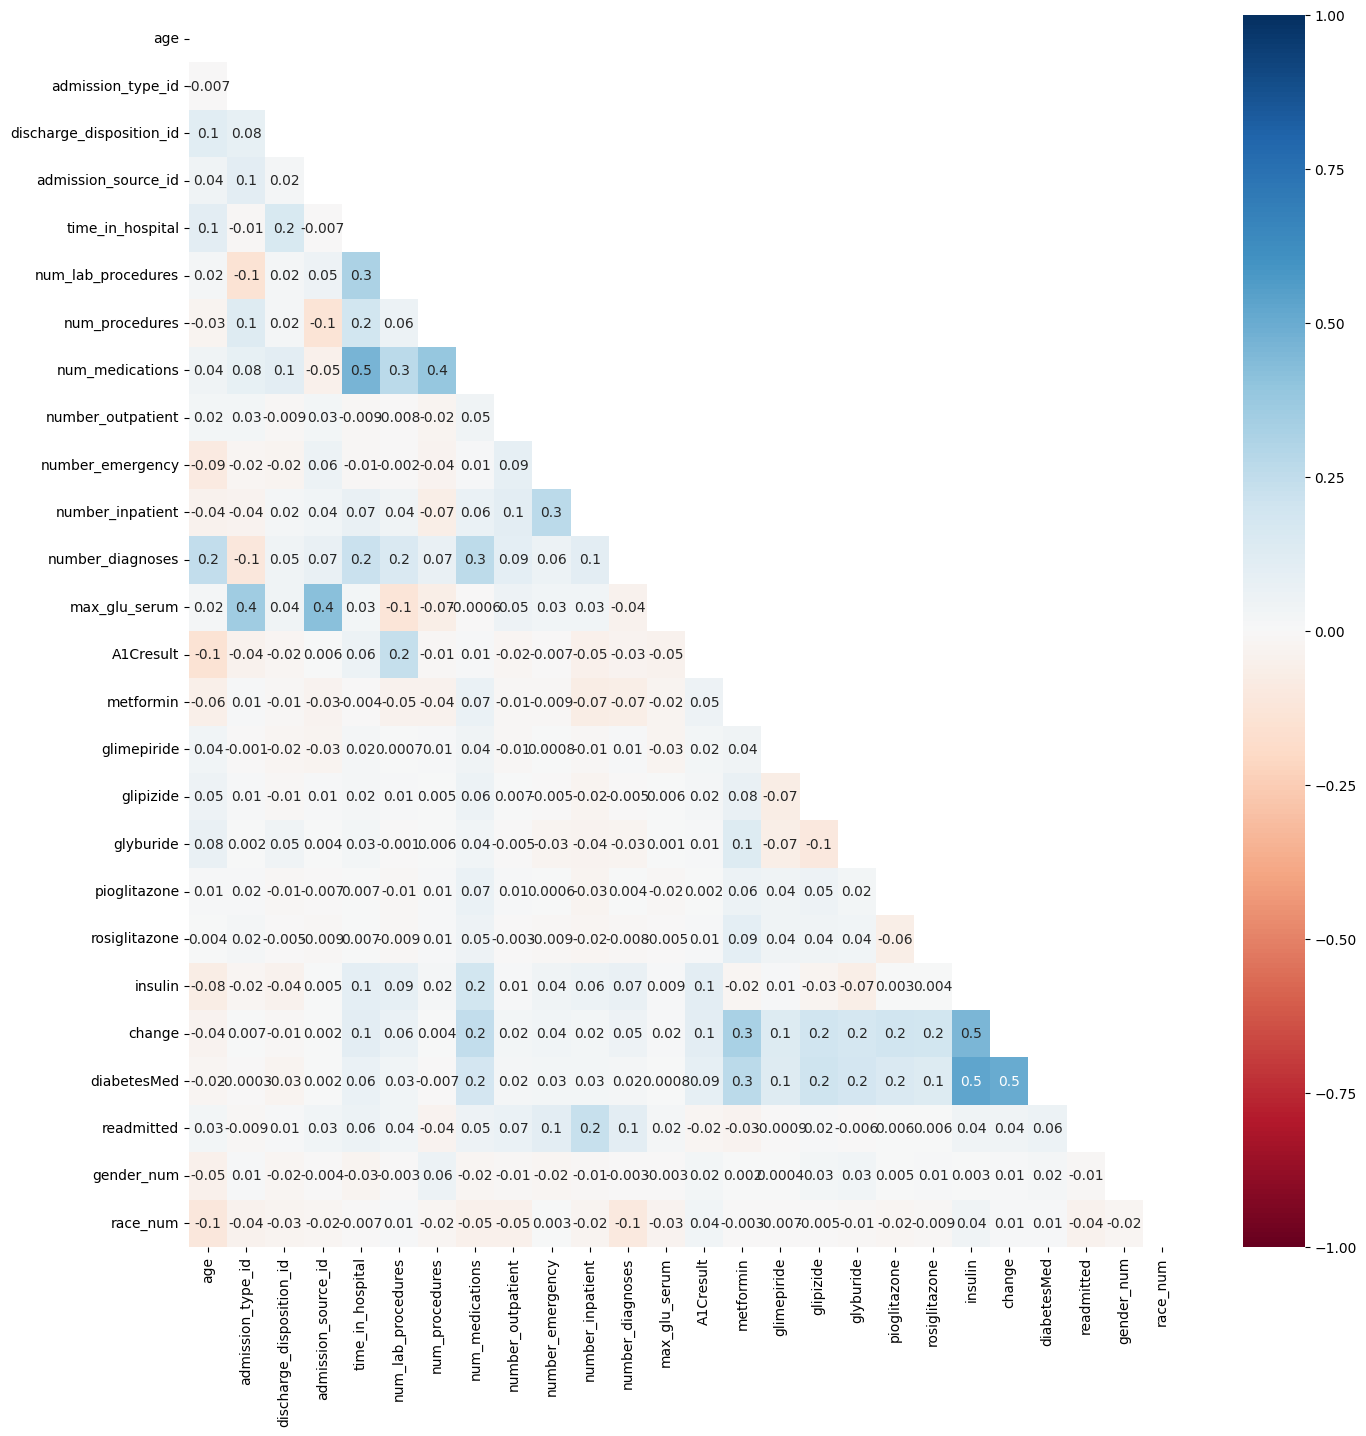

In [44]:
matrix = np.triu(df_eda.corr())
fig, ax = plt.subplots(figsize=(16,16))
sns.heatmap(df_eda.corr(), annot=True, ax=ax, fmt='.1g', vmin=-1, vmax=1, center= 0, mask=matrix, cmap='RdBu')
plt.show()

**The strongest correlation pairs are:**
*   `num_medications` and `time_in_hospital` (corr = 0.5)
*   `change` and `insulin` (corr = 0.5)
*   `change` and `diabetesMed` (corr = 0.5)
*   `insulin` and `diabetesMed` (corr = 0.5)

The target label `readmitted` shows weak correlations with all features, likely because it is categorical and Pearson correlation cannot capture non-linear or complex relationships.

  **2. Patient Analysis** in demographics.

/tmp/ipython-input-3677688621.py:15: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  sns.countplot(data=df, x='gender', hue='readmitted_label', ax=axes[0,0], palette=palette)


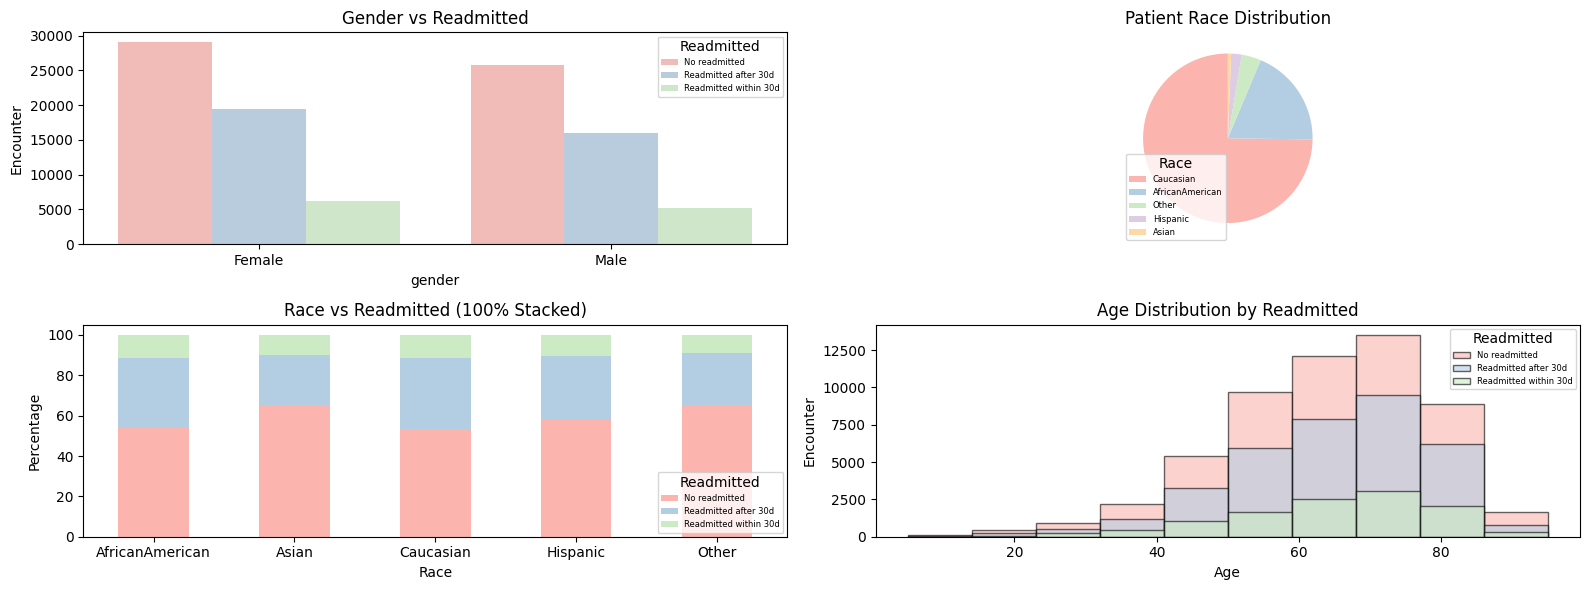

In [45]:
readmit_map = {0: 'No readmitted', 1: 'Readmitted after 30d', 2: 'Readmitted within 30d'}
df['readmitted_label'] = df['readmitted'].map(readmit_map)

# Define color palette
palette = sns.color_palette("Pastel1", 5)

# Crosstab for 100% stacked bar
race_readmit = pd.crosstab(df['race'], df['readmitted_label'])
race_readmit_pct = race_readmit.div(race_readmit.sum(axis=1), axis=0) * 100

# Create figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(16,6))

# 1. Gender vs Readmitted
sns.countplot(data=df, x='gender', hue='readmitted_label', ax=axes[0,0], palette=palette)
axes[0,0].set_title("Gender vs Readmitted")
axes[0,0].set_ylabel("Encounter")
axes[0,0].legend(title="Readmitted", loc='upper right', prop={'size': 6})

# 2. Age vs Readmitted (overlaid histogram)
for i, label in enumerate(df['readmitted_label'].unique()):
    subset = df[df['readmitted_label'] == label]
    axes[1,1].hist(subset['age'], bins=10, alpha=0.6, label=label, color=palette[i], edgecolor='black')
axes[1,1].set_title("Age Distribution by Readmitted")
axes[1,1].set_xlabel("Age")
axes[1,1].set_ylabel("Encounter")
axes[1,1].legend(title="Readmitted", loc='upper right', prop={'size': 6})

# 3. Race Distribution (Pie chart)
race_counts = df['race'].value_counts()
axes[0,1].pie(race_counts, labels=None, startangle=90, colors=palette)
axes[0,1].set_title("Patient Race Distribution")
axes[0,1].legend(race_counts.index, title="Race", loc="lower left", prop={'size': 6})

# 4. Race vs Readmitted (100% stacked bar)
race_readmit_pct.plot(kind='bar', stacked=True, ax=axes[1,0], color=palette)
axes[1,0].set_title("Race vs Readmitted (100% Stacked)")
axes[1,0].set_ylabel("Percentage")
axes[1,0].set_xlabel("Race")
axes[1,0].set_xticklabels(axes[1,0].get_xticklabels(), rotation=0)
axes[1,0].legend(title="Readmitted", loc='lower right', prop={'size': 6})

plt.tight_layout()
plt.show()

  **3. Utilization vs time_in_hospital.**

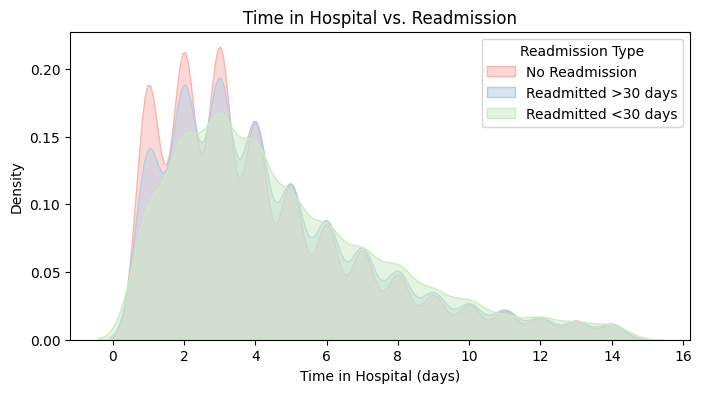

In [46]:
palette = sns.color_palette("Pastel1", 3)
plt.figure(figsize=(8,4))

# KDE for each readmission category with Pastel1 colors
sns.kdeplot(df_eda.loc[df_eda['readmitted'] == 0, 'time_in_hospital'],
            color=palette[0], fill=True, alpha=0.5, label='No Readmission')
sns.kdeplot(df_eda.loc[df_eda['readmitted'] == 1, 'time_in_hospital'],
            color=palette[1], fill=True, alpha=0.5, label='Readmitted >30 days')
sns.kdeplot(df_eda.loc[df_eda['readmitted'] == 2, 'time_in_hospital'],
            color=palette[2], fill=True, alpha=0.5, label='Readmitted <30 days')

plt.xlabel('Time in Hospital (days)')
plt.ylabel('Density')
plt.title('Time in Hospital vs. Readmission')
plt.legend(title='Readmission Type', loc='upper right', fontsize=10)
plt.show()

  **4. Hypothesis Test on Healthcare Utilization**

Perform hypothesis testing on healthcare utilization features, `time_in_hospital`, `num_lab_procedures`, `num_procedures`, `num_medications`, `number_outpatient`, `number_emergency`, `number_inpatient` to test whether there are statistically significant differences in healthcare utilization across readmission groups (No readmission, >30 days, <30 days).

---



**Hypothesis:**
*   **Null hypothesis (H₀):** The mean of each utilization feature is the same across all groups.
*   **Alternative hypothesis (H₁):** At least one group mean differs.



=== time_in_hospital ===
ANOVA F-statistic: 170.2851, p-value: 1.4778e-74
Post-hoc Tukey HSD results:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj lower  upper  reject
-------------------------------------------------
     0      1   0.2411   0.0 0.1935 0.2886   True
     0      2   0.5138   0.0 0.4418 0.5858   True
     1      2   0.2727   0.0 0.1974  0.348   True
-------------------------------------------------


/tmp/ipython-input-3986128190.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='readmitted', y=col, data=df_eda, palette='Pastel1')


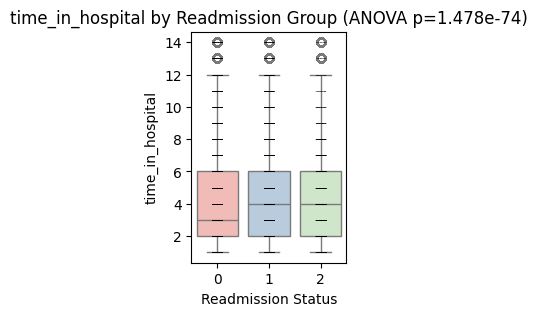

=== num_lab_procedures ===
ANOVA F-statistic: 80.1634, p-value: 1.6326e-35
Post-hoc Tukey HSD results:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     0      1   1.4545    0.0  1.1408 1.7683   True
     0      2    1.844    0.0   1.369  2.319   True
     1      2   0.3894 0.1573 -0.1072 0.8861  False
---------------------------------------------------


/tmp/ipython-input-3986128190.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='readmitted', y=col, data=df_eda, palette='Pastel1')


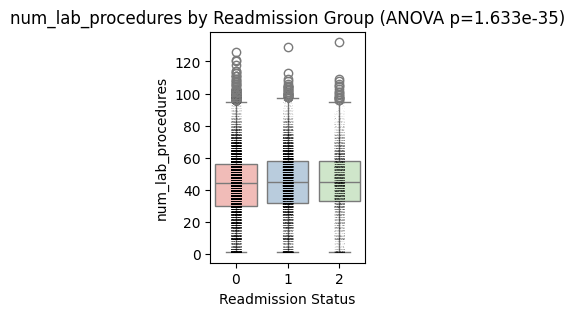

=== num_procedures ===
ANOVA F-statistic: 103.4488, p-value: 1.3134e-45
Post-hoc Tukey HSD results:
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     0      1  -0.1606    0.0 -0.1878 -0.1334   True
     0      2  -0.1294    0.0 -0.1705 -0.0882   True
     1      2   0.0313 0.2039 -0.0118  0.0743  False
----------------------------------------------------


/tmp/ipython-input-3986128190.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='readmitted', y=col, data=df_eda, palette='Pastel1')


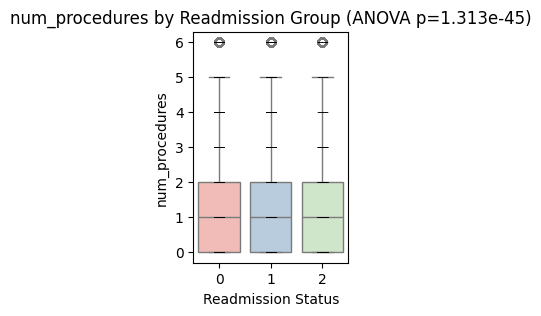

=== num_medications ===
ANOVA F-statistic: 136.7563, p-value: 4.8661e-60
Post-hoc Tukey HSD results:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj lower  upper  reject
-------------------------------------------------
     0      1   0.6124   0.0 0.4829  0.742   True
     0      2   1.2328   0.0 1.0367 1.4289   True
     1      2   0.6204   0.0 0.4153 0.8254   True
-------------------------------------------------


/tmp/ipython-input-3986128190.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='readmitted', y=col, data=df_eda, palette='Pastel1')


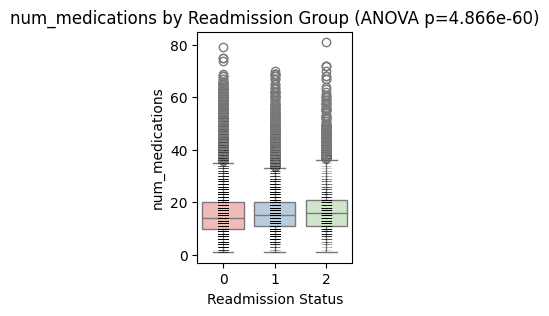

=== number_outpatient ===
ANOVA F-statistic: 355.1646, p-value: 1.9492e-154
Post-hoc Tukey HSD results:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
     0      1   0.2232   0.0   0.203  0.2434   True
     0      2   0.1638   0.0  0.1333  0.1943   True
     1      2  -0.0594   0.0 -0.0913 -0.0275   True
---------------------------------------------------


/tmp/ipython-input-3986128190.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='readmitted', y=col, data=df_eda, palette='Pastel1')


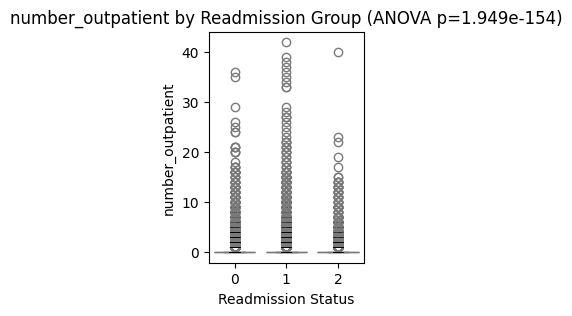

=== number_emergency ===
ANOVA F-statistic: 573.1929, p-value: 2.8659e-248
Post-hoc Tukey HSD results:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj lower  upper  reject
-------------------------------------------------
     0      1   0.1744   0.0 0.1597 0.1892   True
     0      2   0.2481   0.0 0.2257 0.2704   True
     1      2   0.0736   0.0 0.0503  0.097   True
-------------------------------------------------


/tmp/ipython-input-3986128190.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='readmitted', y=col, data=df_eda, palette='Pastel1')


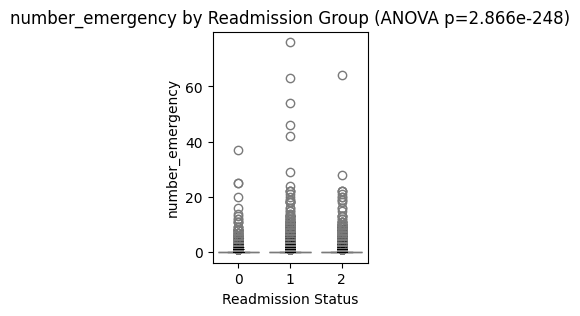

=== number_inpatient ===
ANOVA F-statistic: 2962.9881, p-value: 0.0000e+00
Post-hoc Tukey HSD results:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj lower  upper  reject
-------------------------------------------------
     0      1    0.457   0.0 0.4374 0.4766   True
     0      2    0.842   0.0 0.8124 0.8717   True
     1      2    0.385   0.0  0.354  0.416   True
-------------------------------------------------


/tmp/ipython-input-3986128190.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='readmitted', y=col, data=df_eda, palette='Pastel1')


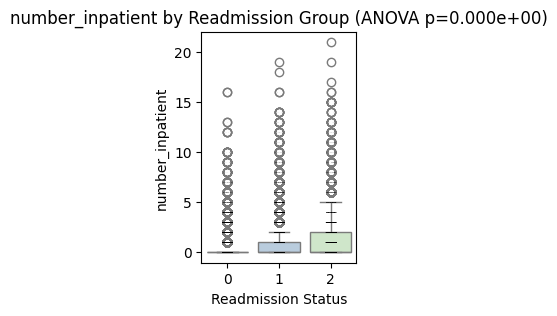

              Feature  F-Statistic        p-value
0    time_in_hospital   170.285074   1.477783e-74
1  num_lab_procedures    80.163375   1.632622e-35
2      num_procedures   103.448753   1.313374e-45
3     num_medications   136.756282   4.866053e-60
4   number_outpatient   355.164555  1.949186e-154
5    number_emergency   573.192854  2.865890e-248
6    number_inpatient  2962.988108   0.000000e+00


In [70]:
utilization = [
    'time_in_hospital', 'num_lab_procedures', 'num_procedures',
    'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient'
]

results = []

for col in utilization:
    # Group data by readmission class
    groups = [df_eda[df_eda['readmitted'] == g][col].dropna() for g in df_eda['readmitted'].unique()]

    # One-way ANOVA
    f_stat, p_val = stats.f_oneway(*groups)
    results.append((col, f_stat, p_val))

    print(f"=== {col} ===")
    print(f"ANOVA F-statistic: {f_stat:.4f}, p-value: {p_val:.4e}")

    # If significant, run Tukey HSD
    if p_val < 0.05:
        print("Post-hoc Tukey HSD results:")
        tukey = pairwise_tukeyhsd(endog=df_eda[col], groups=df_eda['readmitted'], alpha=0.05)
        print(tukey.summary())

    # ----- Visualization -----
    plt.figure(figsize=(2, 3))
    sns.boxplot(x='readmitted', y=col, data=df_eda, palette='Pastel1')
    sns.stripplot(x='readmitted', y=col, data=df_eda, color='black', size=0.2, jitter=True, alpha=0.3)
    plt.title(f"{col} by Readmission Group (ANOVA p={p_val:.3e})")
    plt.xlabel("Readmission Status")
    plt.ylabel(col)
    plt.show()
    # -------------------------

# Convert results to DataFrame for summary
anova_results = pd.DataFrame(results, columns=['Feature', 'F-Statistic', 'p-value'])
print(anova_results)

The ANOVA results show that all selected healthcare utilization features differ significantly across readmission groups (p < 0.001). This suggests that higher utilization of hospital resources (e.g., inpatient visits, emergency visits, and medications) is strongly associated with patient readmission outcomes.

## Data Preparation for ML Model

  **1. Drop identifiers**

In [47]:
identifiers = ['patient_nbr', 'encounter_id']
df = df.drop(columns=identifiers)

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 101763 entries, 0 to 101765
Data columns (total 35 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   race                      101763 non-null  object  
 1   gender                    101763 non-null  object  
 2   age                       101763 non-null  int64   
 3   admission_type_id         101763 non-null  int64   
 4   discharge_disposition_id  101763 non-null  int64   
 5   admission_source_id       101763 non-null  int64   
 6   time_in_hospital          101763 non-null  int64   
 7   num_lab_procedures        101763 non-null  int64   
 8   num_procedures            101763 non-null  int64   
 9   num_medications           101763 non-null  int64   
 10  number_outpatient         101763 non-null  int64   
 11  number_emergency          101763 non-null  int64   
 12  number_inpatient          101763 non-null  int64   
 13  diag_1                    101742 n

  **2.Handle `diag_1`, `diag_2`, `diag_3` features.**
  <br>
    Diag features indicate the diagnoses of the cause of the patien's health problem.
  <br>
*   diag_1: First diagnose
*   diag_2: Second diagnose
*   diag_3: Third diagnose
  <br>
  
  They are coded in ICD-9 code (https://en.wikipedia.org/wiki/List_of_ICD-9_codes), and this data contains about 800+ distinct codes. Group 800+ ICD-9 codes into 18 broad health categories to simplify features and improve model interpretability. Aggregate based on first 3 digits as following:
<br>* List of ICD-9 codes 001–139: infectious and parasitic diseases
<br>* List of ICD-9 codes 140–239: neoplasms
<br>* List of ICD-9 codes 240–279: endocrine, nutritional and metabolic diseases, and immunity disorders
<br>* List of ICD-9 codes 280–289: diseases of the blood and blood-forming organs
<br>* List of ICD-9 codes 290–319: mental disorders
<br>* List of ICD-9 codes 320–389: diseases of the nervous system and sense organs
<br>* List of ICD-9 codes 390–459: diseases of the circulatory system
<br>* List of ICD-9 codes 460–519: diseases of the respiratory system
<br>* List of ICD-9 codes 520–579: diseases of the digestive system
<br>* List of ICD-9 codes 580–629: diseases of the genitourinary system
<br>* List of ICD-9 codes 630–679: complications of pregnancy, childbirth, and the puerperium
<br>* List of ICD-9 codes 680–709: diseases of the skin and subcutaneous tissue
<br>* List of ICD-9 codes 710–739: diseases of the musculoskeletal system and connective tissue
<br>* List of ICD-9 codes 740–759: congenital anomalies
<br>* List of ICD-9 codes 760–779: certain conditions originating in the perinatal period
<br>* List of ICD-9 codes 780–799: symptoms, signs, and ill-defined conditions
<br>* List of ICD-9 codes 800–999: injury and poisoning
<br>* List of ICD-9 codes E and V codes: external causes of injury and supplemental classification
<br>
After that we will fill the missing values with E and V codes




In [49]:
cols = ['diag_1', 'diag_2', 'diag_3']

In [50]:
# Replace any code starting with 'V' or 'E' with 0
df[cols] = df[cols].apply(lambda x: x.str.replace(r'^[VE].*', '0', regex=True))

# Replace missing values with -1
df[cols] = df[cols].fillna(-1).astype(float)

In [51]:
# Define bins and labels
bins = [-1, 0, 140, 240, 280, 290, 320, 390, 460, 520, 580, 630, 680, 710, 740, 760, 780, 800, 1000]
labels = list(range(len(bins)-1))  # 0 to 17

# Apply to all 3 columns
df[cols] = df[cols].apply(lambda x: pd.cut(x, bins=bins, labels=labels, right=False).astype(float))

In [52]:
# check if grouping works or not
for col in cols:
    print(f"Value counts for {col}:")
    print(df[col].value_counts().sort_index())
    print("\n")

Value counts for diag_1:
diag_1
0.0        21
1.0      4413
2.0      3433
3.0     11459
4.0      1103
5.0      2262
6.0      1211
7.0     30335
8.0     10407
9.0      9208
10.0     5078
11.0      687
12.0     2530
13.0     4957
14.0       51
16.0     7636
17.0     6972
Name: count, dtype: int64


Value counts for diag_2:
diag_2
0.0       358
1.0      4467
2.0      2547
3.0     21017
4.0      2926
5.0      2657
6.0      1286
7.0     31364
8.0     10251
9.0      3962
10.0     7987
11.0      415
12.0     3596
13.0     1764
14.0      108
16.0     4632
17.0     2426
Name: count, dtype: int64


Value counts for diag_3:
diag_3
0.0      1423
1.0      6918
2.0      1856
3.0     26308
4.0      2490
5.0      3136
6.0      1766
7.0     29917
8.0      6774
9.0      3572
10.0     6327
11.0      309
12.0     2488
13.0     1915
14.0       96
16.0     4523
17.0     1945
Name: count, dtype: int64




  **3. Drop categorical features**

In [53]:
categorical = ['admission_source', 'admission_type', 'discharge_disposition']
df = df.drop(columns=categorical)

  **4. Create Dummy variables for `gender` and `race`.**

In [54]:
df = pd.concat([df, pd.get_dummies(df[['gender','race']])], axis=1).drop(['gender','race'], axis=1)

In [55]:
df = df.drop(columns=['gender_num', 'race_num'])

In [56]:
df = df.drop(columns=['readmitted_label'])

In [57]:
df = df.astype({col: int for col in df.select_dtypes(include='bool').columns})

In [58]:
# Save DataFrame to CSV
#df.to_csv('diabetes_df.csv', index=False)

# Download the CSV
#files.download('diabetes_df.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  **5. Split Data** : 70% for train data, 15% for validation data and 15% for test data.

In [59]:
y = df['readmitted']
X = df.drop(['readmitted'], axis=1)

In [60]:
X_train, X_valtest, y_train, y_valtest = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, test_size=0.5, random_state=42)

  **6. Scale feature**

In [61]:
sc_X = StandardScaler()

# Fit on train, apply same transform to val & test
Xsc_train = sc_X.fit_transform(X_train)
Xsc_val   = sc_X.transform(X_val)
Xsc_test  = sc_X.transform(X_test)